<a href="https://colab.research.google.com/github/OOWUOR/Generative-AI-Based-Spatio-Temporal-Fusion/blob/main/Group6a_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#from google.colab import files
#from google.colab import drive
#drive.mount('/content/drive')

In [8]:
#https://www.youtube.com/watch?v=M1lgXr4Xcns
import pandas as pd
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import preprocess_input
from matplotlib import pyplot as plt
import requests
from io import BytesIO

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#pd.read_json("images.json").iloc[1,1]

In [9]:
image_metadata = pd.read_json("https://github.ugent.be/raw/vowuor/Group_6a_Deep_Learning/49be8ed418a9b75db4117e3e6404c706951bea8e/Data/images.json?token=GHSAT0AAAAAAAAAPOU4GR63EG72GHF2QW6IZPRFHOA")
def extract_and_concat(image_metadata, column_index):
    df_list = []

    for i in range(len(image_metadata)):
        data_dict = image_metadata.iloc[i, column_index]
        df_i = pd.DataFrame([data_dict])
        df_list.append(df_i)

    return pd.concat(df_list, ignore_index=True)

# Define the column indices for each category
categories = ['pasta', 'dessert', 'salad', 'bbq', 'sushi']
column_indices = [0, 1, 2, 3, 4]

# Create DataFrames for each category
dfs = {}
for category, col_index in zip(categories, column_indices):
    dfs[category] = extract_and_concat(image_metadata, col_index)
# Create a new DataFrame with columns corresponding to categories and only 'url_q_cdn' columns
per_category_df = pd.DataFrame({f"{category}": df['url_sq'] for category, df in dfs.items()})

In [ ]:
#per_category_df.head()

In [10]:
# This might take a while
# image dimensions
img_size = (224, 224)
# to load and preprocess images from URLs
def load_and_preprocess_image(url_series, target_size=(224, 224)):
    url_str = str(url_series.iloc[0])
    try:
        response = requests.get(url_str)
        if response.status_code == 200:
            img = load_img(BytesIO(response.content), target_size=target_size)
            img_array = img_to_array(img)
            img_array = preprocess_input(img_array)
            return img_array
        else:
            print(f"Failed to download image from {url_str}")
            return None
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

# Iterate over the DataFrame and load images for each category
image_data = []
labels = []

for category in categories:
    image_column = f"{category}"
    df_category = per_category_df[[image_column, category]].dropna()

    for index, row in df_category.iterrows():
        img_array = load_and_preprocess_image(row[[category]])

        if img_array is not None:
            image_data.append(img_array)
            labels.append(f'{category}')

# Convert the lists to NumPy arrays
image_data = np.array(image_data)
labels = np.array(labels)
print(f'Done loading {image_data.shape[0]} images')
# Save the NumPy arrays to disk
np.save('image_data.npy', image_data)
np.save('labels.npy', labels)

Done loading 1500 images


In [ ]:
np.unique(labels)
#np.save('/content/drive/MyDrive/image_data.npy', image_data)
#np.save('/content/drive/MyDrive/image_labels.npy', image_data)

array(['bbq', 'dessert', 'pasta', 'salad', 'sushi'], dtype='<U7')

# We can start from here if it takes a long time to load files

In [ ]:
#np.load("labels.npy", allow_pickle = True)[1199]
image_data = np.load("image_data.npy",  fix_imports=True,  mmap_mode='r+')
labels = np.load("labels.npy",  fix_imports=True,  mmap_mode='r+')

# Else, continue here

In [11]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

In [20]:
# Lets have a look at preprocessed images in the test set
from IPython.display import clear_output
test_images, labels = image_data.copy(), y.copy()

def show_sample_images(sample_images, sample_labels, sample_predictions=None, num_rows=5, num_cols=10,
                        plot_title=None, fig_size=None):

    assert sample_images.shape[0] == num_rows * num_cols

    FOOD_LABELS = {
        0: 'bbq',
        1: 'dessert',
        2: 'pasta',
        3: 'salad',
        4: 'shushi'
    }

    with sns.axes_style("whitegrid"):
        sns.set_context("notebook", font_scale=1.1)
        sns.set_style({"font.sans-serif": ["Arial", "Arial", "Calibri", "DejaVu Sans"]})

        f, ax = plt.subplots(num_rows, num_cols, figsize=((25, 10) if fig_size is None else fig_size),
                             gridspec_kw={"wspace": 0.02, "hspace": 0.30}, squeeze=True, facecolor = "#FFFEFD")

        for r in range(num_rows):
            for c in range(num_cols):
                image_index = r * num_cols + c
                ax[r, c].axis("off")
                # This will show selected images
                ax[r, c].imshow(sample_images[image_index], cmap="Greys")

                if sample_predictions is None:
                    # show the actual labels in the cell title
                    title = ax[r, c].set_title(f"{FOOD_LABELS[sample_labels[image_index]]}", color = "#990148")
                else:
                    # else check if prediction matches actual value
                    true_label = sample_labels[image_index]
                    pred_label = sample_predictions[image_index]
                    prediction_matches_true = (sample_labels[image_index] == sample_predictions[image_index])
                    if prediction_matches_true:
                        # if actual == prediction, cell title is prediction shown in green font
                        title = FOOD_LABELS[true_label]
                        title_color = 'g'
                        # Create an instance of Text object for title

                    else:
                        # if actual != prediction, cell title is actual/prediction in red font
                        title = f"{FOOD_LABELS[true_label]}/{FOOD_LABELS[pred_label]}"
                        title_color = 'r'
                        title_obj = ax[r, c].text(0.5, 1.05, title, ha='center', va='center', transform=ax[r, c].transAxes,color="#990148", fontsize=12)  # Adjust color and fontsize as needed
                        # Set the bbox using the Text object
                        title_obj.set_bbox(dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.5'))
                    # display cell title
                    title = ax[r, c].set_title(title, bbox=dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.5'))
                    plt.setp(title, color=title_color)
        # set plot title, if one specified
        if plot_title is not None:
            f.suptitle(plot_title, color = "#6C58CE", fontsize = 18, y = 0.95)

        clear_output()
        plt.show()
        plt.close()

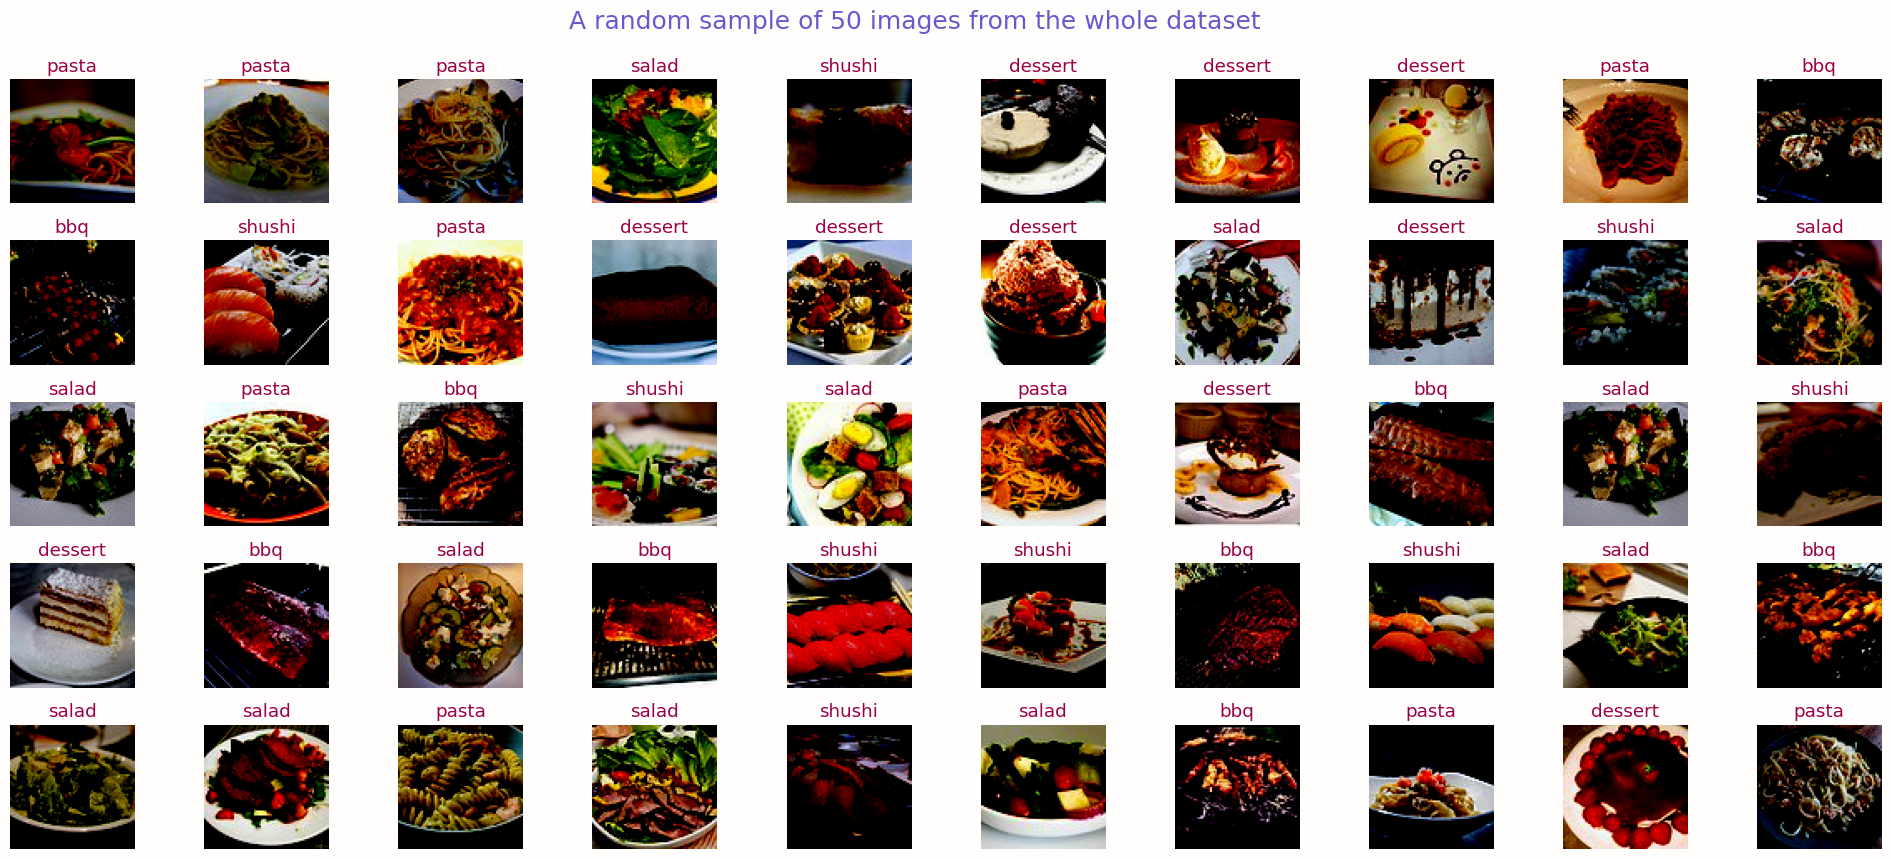

In [21]:
import seaborn as sns
from keras.utils import to_categorical
sample_size = 50
rand_indexes = np.random.randint(0, len(image_data), sample_size)
sample_images = test_images[rand_indexes]
sample_labels = labels[rand_indexes ]
#num_rows =
#num_cols =
show_sample_images(sample_images,  sample_labels, plot_title= f'A random sample of {sample_size} images from the whole dataset', fig_size=(25,10))